In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
from scipy.stats import norm, t
import matplotlib.pyplot as plt

In [2]:
historical_trends_in_days = 800
simulation_length_in_days = 100
mc_sims = 1000 # number of simulations
initial_investment = 1.0

In [3]:
def dot_product(df: pd.DataFrame, weights: dict[str, float]):
    dp = np.zeros(len(df))
    for c in df.columns:
        mult = weights.get(c, 0)
        dp += df[c].to_numpy()*mult
    return dp

In [4]:
# Import data
def getData(stocks, start, end):
    stockData = yf.download(" ".join(stocks), start=start, end=end)
    stockData = stockData['Close']
    returns = stockData.pct_change()
    meanReturns = returns.mean()
    covMatrix = returns.cov()
    return returns, meanReturns, covMatrix

# Portfolio Performance
def portfolioPerformance(weights, meanReturns, covMatrix, Time):
    returns = np.sum(meanReturns*weights)*Time
    std = np.sqrt( np.dot(weights.T, np.dot(covMatrix, weights)) ) * np.sqrt(Time)
    return returns, std

stockList = ['GOOGL' ,'AMZN', 'AAPL', 'BP', 'AI', 'INTC', 'LYFT', 'MSFT', 'MRNA', 'NFLX', 'TSLA', 'BRK-B', 'UBS', 'VUSA.L', 'VZ', 'SPCE']
stocks = [stock for stock in stockList]
endDate = dt.datetime.now()
startDate = endDate - dt.timedelta(days=historical_trends_in_days)

returns, meanReturns, covMatrix = getData(stocks, start=startDate, end=endDate)
returns = returns.dropna()

weights_dict = {
    'GOOGL': 0.1157,
    'AMZN': 0.0272,
    'AAPL': 0.0433,
    'BP': 0.009,
    'AI': 0.019,
    'INTC': 0.0148,
    'LYFT': 0.032,
    'MSFT': 0.2301,
    'MRNA': 0.0153,
    'NFLX': 0.0615,
    'TSLA': 0.0306,
    'BRK-B':0.1981,
    'UBS': 0.0495,
    'VUSA.L':0.1192,
    'VZ':0.0290,
    'SPCE': 0.0056
}

sorted_stockList = sorted(stockList)
weights = np.array([weights_dict.get(s,0) for s in sorted_stockList])

returns['portfolio'] = returns.dot(weights)

[*********************100%***********************]  16 of 16 completed
C:\Users\qlegr\AppData\Local\Temp\ipykernel_36040\2937593607.py:5: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = stockData.pct_change()


In [5]:
def historicalVaR(returns, alpha=5):
    """
    Read in a pandas dataframe of returns / a pandas series of returns
    Output the percentile of the distribution at the given alpha confidence level
    """
    if isinstance(returns, pd.Series):
        return np.percentile(returns, alpha)

    # A passed user-defined-function will be passed a Series for evaluation.
    elif isinstance(returns, pd.DataFrame):
        return returns.aggregate(historicalVaR, alpha=alpha)

    else:
        raise TypeError("Expected returns to be dataframe or series")

def historicalCVaR(returns, alpha=5):
    """
    Read in a pandas dataframe of returns / a pandas series of returns
    Output the CVaR for dataframe / series
    """
    if isinstance(returns, pd.Series):
        belowVaR = returns <= historicalVaR(returns, alpha=alpha)
        return returns[belowVaR].mean()

    # A passed user-defined-function will be passed a Series for evaluation.
    elif isinstance(returns, pd.DataFrame):
        return returns.aggregate(historicalCVaR, alpha=alpha)

    else:
        raise TypeError("Expected returns to be dataframe or series")

hVaR = -historicalVaR(returns['portfolio'], alpha=5)*np.sqrt(simulation_length_in_days)
hCVaR = -historicalCVaR(returns['portfolio'], alpha=5)*np.sqrt(simulation_length_in_days)
pRet, pStd = portfolioPerformance(weights, meanReturns, covMatrix, simulation_length_in_days)

print('Expected Portfolio Return:      ', round(initial_investment*pRet,2))
print('Value at Risk 95th CI    :      ', round(initial_investment*hVaR,2))
print('Conditional VaR 95th CI  :      ', round(initial_investment*hCVaR,2))

Expected Portfolio Return:       0.08
Value at Risk 95th CI    :       0.17
Conditional VaR 95th CI  :       0.24


In [6]:

def var_parametric(portofolioReturns, portfolioStd, distribution='normal', alpha=5, dof=6):
    # because the distribution is symmetric
    if distribution == 'normal':
        VaR = norm.ppf(1-alpha/100)*portfolioStd - portofolioReturns
    elif distribution == 't-distribution':
        nu = dof
        VaR = np.sqrt((nu-2)/nu) * t.ppf(1-alpha/100, nu) * portfolioStd - portofolioReturns
    else:
        raise TypeError("Expected distribution type 'normal'/'t-distribution'")
    return VaR

def cvar_parametric(portofolioReturns, portfolioStd, distribution='normal', alpha=5, dof=6):
    if distribution == 'normal':
        CVaR = (alpha/100)**-1 * norm.pdf(norm.ppf(alpha/100))*portfolioStd - portofolioReturns
    elif distribution == 't-distribution':
        nu = dof
        xanu = t.ppf(alpha/100, nu)
        CVaR = -1/(alpha/100) * (1-nu)**(-1) * (nu-2+xanu**2) * t.pdf(xanu, nu) * portfolioStd - portofolioReturns
    else:
        raise TypeError("Expected distribution type 'normal'/'t-distribution'")
    return CVaR

normVaR = var_parametric(pRet, pStd)
normCVaR = cvar_parametric(pRet, pStd)

tVaR = var_parametric(pRet, pStd, distribution='t-distribution')
tCVaR = cvar_parametric(pRet, pStd, distribution='t-distribution')

print("Normal VaR 95th CI       :      ", round(initial_investment*normVaR,2))
print("Normal CVaR 95th CI      :      ", round(initial_investment*normCVaR,2))
print("t-dist VaR 95th CI       :      ", round(initial_investment*tVaR,2))
print("t-dist CVaR 95th CI      :      ", round(initial_investment*tCVaR,2))

Normal VaR 95th CI       :       0.11
Normal CVaR 95th CI      :       0.16
t-dist VaR 95th CI       :       0.1
t-dist CVaR 95th CI      :       0.17


In [15]:
def get_mc_sims_results(mean_returns, cov_matrix, sim_length_days, num_sims, initial_investment, portfolio_weights):
    meanM = np.full(shape=(sim_length_days, len(portfolio_weights)), fill_value=mean_returns)
    meanM = meanM.T

    portfolio_sims = np.full(shape=(sim_length_days, num_sims), fill_value=0.0)
    for m in range(0, num_sims):
        # MC loops
        Z = np.random.normal(size=(sim_length_days, len(portfolio_weights)))
        L = np.linalg.cholesky(cov_matrix)
        dailyReturns = meanM + np.inner(L, Z)
        portfolio_sims[:,m] = np.cumprod(np.inner(portfolio_weights, dailyReturns.T)+1)*initial_investment

    return portfolio_sims

In [16]:
portfolio_sims = get_mc_sims_results(
    mean_returns=meanReturns,
    cov_matrix=covMatrix,
    sim_length_days=simulation_length_in_days,
    num_sims=mc_sims,
    initial_investment=initial_investment,
    portfolio_weights=weights,
)

In [17]:
portfolio_sims.shape

(100, 1000)

In [18]:
portfolio_sims_mean = np.mean(portfolio_sims, axis=1)
portfolio_sims_05 = np.percentile(portfolio_sims, 5, axis=1)
portfolio_sims_95 = np.percentile(portfolio_sims, 95, axis=1)
portfolio_sims_50 = np.percentile(portfolio_sims, 50, axis=1)

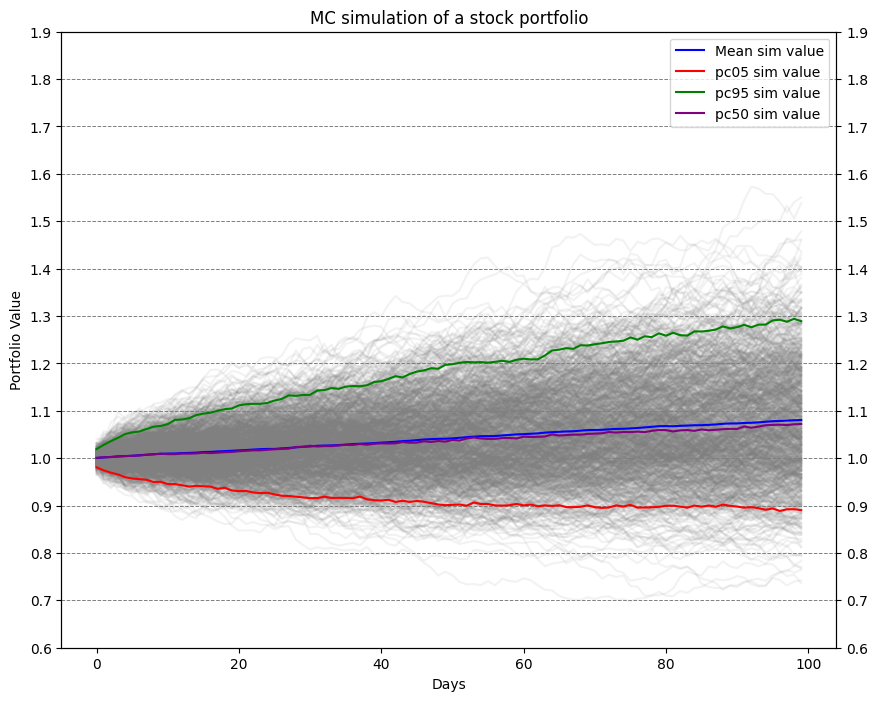

In [19]:
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(portfolio_sims, alpha = 0.1, color = 'gray')
ax.plot(portfolio_sims_mean, color = 'blue', label = "Mean sim value")
ax.plot(portfolio_sims_05, color = 'red', label = "pc05 sim value")
ax.plot(portfolio_sims_95, color = 'green', label = "pc95 sim value")
ax.plot(portfolio_sims_50, color = 'purple', label = "pc50 sim value")
ax.set_xlabel("Days")
ax.set_ylabel("Portfolio Value")
ax.set_title('MC simulation of a stock portfolio')
y_ticks = ax.get_yticks()
increment = 0.1
y_ticks = np.arange(min(y_ticks), max(y_ticks)+increment, increment)
ax.set_yticks(y_ticks)
ax.grid(True, axis='y', linestyle='--', color='gray', linewidth=0.7)
ax_right = ax.twinx()
ax_right.set_ylim(ax.get_ylim())
ax_right.set_yticks(ax.get_yticks())
ax.legend(loc="best")
plt.show()

In [11]:
def mcVaR(returns, alpha=5):
    """ Input: pandas series of returns
        Output: percentile on return distribution to a given confidence level alpha
    """
    if isinstance(returns, pd.Series):
        return np.percentile(returns, alpha)
    else:
        raise TypeError("Expected a pandas data series.")

def mcCVaR(returns, alpha=5):
    """ Input: pandas series of returns
        Output: CVaR or Expected Shortfall to a given confidence level alpha
    """
    if isinstance(returns, pd.Series):
        belowVaR = returns <= mcVaR(returns, alpha=alpha)
        return returns[belowVaR].mean()
    else:
        raise TypeError("Expected a pandas data series.")

In [12]:
portResults = pd.Series(portfolio_sims[-1,:])

VaR = initial_investment - mcVaR(portResults, alpha=5)
CVaR = initial_investment - mcCVaR(portResults, alpha=5)

print('VaR {}'.format(round(VaR,2)))
print('CVaR {}'.format(round(CVaR,2)))

VaR 0.11
CVaR 0.15


In [13]:
print("\nVaR:")

print(' historical VaR 95th CI   :      ', round(initial_investment*hVaR,2))
print(" Normal VaR 95th CI       :      ", round(initial_investment*normVaR,2))
print(" t-dist VaR 95th CI       :      ", round(initial_investment*tVaR,2))
print(" MC VaR  95th CI          :      ", round(VaR,2))


print("\nCVaR:")

print(' historical CVaR 95th CI  :      ', round(initial_investment*hCVaR,2))
print(" Normal CVaR 95th CI      :      ", round(initial_investment*normCVaR,2))
print(" t-dist CVaR 95th CI      :      ", round(initial_investment*tCVaR,2))
print(" MC CVaR 95th CI          :      ", round(CVaR,2))


VaR:
 historical VaR 95th CI   :       0.17
 Normal VaR 95th CI       :       0.11
 t-dist VaR 95th CI       :       0.1
 MC VaR  95th CI          :       0.11

CVaR:
 historical CVaR 95th CI  :       0.24
 Normal CVaR 95th CI      :       0.16
 t-dist CVaR 95th CI      :       0.17
 MC CVaR 95th CI          :       0.15
